#Librerie

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
import tensorflow
from sklearn.preprocessing import LabelEncoder



# Importazione dei dati



Ognuno dei tre dataset selezionati contiene file audio relativi a differenti frasi dette da diverse persone con diversi stati d'animo, tra i quali:
- Tristezza
- Rabbia
- Disgusto
- Paura
- Felicità
- Neutralità
- Sorpresa
- Emozione sconosciuta

In [ ]:
Ravdess = '/content/drive/MyDrive/Ravdess/'
Crema = '/content/drive/MyDrive/CREMA-D/'
Tess = '/content/drive/MyDrive/TESS Toronto emotional speech set data/'

Di seguito sono definite le tre funzioni che estraggono i percorsi dei vari file audio e la relativa emozione associata

In [ ]:
# Sample: 03-01-01-01-01-01-01.wav
def extract_dir_RAVDESS(dataset_path):
  file_paths = []
  file_emotions = []
  for actor in os.listdir(dataset_path):
    if actor != '.DS_Store':
      for audio in os.listdir(dataset_path + actor):
        if audio != '.DS_Store':
          audio_dir = dataset_path + actor + '/' + audio
          file_paths.append(audio_dir)
          file_emotion = audio_dir.split('-')[2]
          file_emotions.append(int(file_emotion))
  return file_paths,file_emotions

# Sample: 1001_IEO_ANG_HI
def extract_dir_CREMA(dataset_path):
  file_paths = []
  file_emotions = []
  for audio in os.listdir(dataset_path):
    if audio != '.DS_Store':
      audio_dir = dataset_path + audio
      file_paths.append(audio_dir)
      emotion = audio_dir.split('_')[2]
      if  emotion == 'SAD':
          file_emotions.append('sad')
      elif emotion == 'ANG':
            file_emotions.append('angry')
      elif emotion == 'DIS':
            file_emotions.append('disgust')
      elif emotion == 'FEA':
            file_emotions.append('fear')
      elif emotion == 'HAP':
            file_emotions.append('happy')
      elif emotion == 'NEU':
            file_emotions.append('neutral')
      else:
          file_emotions.append('Unknown')
  return file_paths,file_emotions

# Sample: YAF_back_sad.wav
def extract_dir_TESS(dataset_path):

  tess_directory_list = os.listdir(dataset_path)

  file_emotions = []
  file_paths = []

  for dir in tess_directory_list:
    if dir != '.DS_Store':
        directories = os.listdir(Tess + dir)
        for file in directories:
          try:
            if file != '.DS_Store':
              part = file.split('.')[0]
              part = part.split('_')[2]
              if part =='ps':
                file_emotions.append('surprise')
                file_paths.append(Tess + dir + '/' + file)
              else:
                file_emotions.append(part)
                file_paths.append(Tess + dir + '/' + file)
          except:
            print(file)
            pass
  return file_paths,file_emotions


In [ ]:
paths_rav,emotions_rav = extract_dir_RAVDESS(Ravdess)
paths_cre,emotions_cre = extract_dir_CREMA(Crema)
paths_tess,emotions_tess = extract_dir_TESS(Tess)

In [ ]:
# dataframe relativo al dataset RAVDESS
emotions_df_rav = pd.DataFrame(emotions_rav, columns=['Emotions'])
path_df_rav = pd.DataFrame(paths_rav, columns=['Path'])
Ravdess_df = pd.concat([path_df_rav,emotions_df_rav], axis=1)
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

# dataframe relativo al dataset CREMA
emotions_df_cre = pd.DataFrame(emotions_cre, columns=['Emotions'])
path_df_cre = pd.DataFrame(paths_cre, columns=['Path'])
Crema_df = pd.concat([path_df_cre,emotions_df_cre], axis=1)


# dataframe relativo al dataset TESS
emotions_df_tess = pd.DataFrame(emotions_tess, columns=['Emotions'])
path_df_tess = pd.DataFrame(paths_tess, columns=['Path'])
Tess_df = pd.concat([path_df_tess,emotions_df_tess], axis=1)

# concatenazione dei tre datasets
Dataset_df = pd.concat([Ravdess_df,Crema_df, Tess_df], axis=0)
Dataset_df.to_csv('Dataset_df', index=False)
Dataset_df


,Path,Emotions
0,/content/drive/MyDrive/Ravdess/Actor_07/03-01-...,neutral
1,/content/drive/MyDrive/Ravdess/Actor_07/03-01-...,neutral
2,/content/drive/MyDrive/Ravdess/Actor_07/03-01-...,neutral
3,/content/drive/MyDrive/Ravdess/Actor_07/03-01-...,neutral
4,/content/drive/MyDrive/Ravdess/Actor_07/03-01-...,neutral
...,...,...
2795,/content/drive/MyDrive/TESS Toronto emotional ...,disgust
2796,/content/drive/MyDrive/TESS Toronto emotional ...,disgust
2797,/content/drive/MyDrive/TESS Toronto emotional ...,disgust
2798,/content/drive/MyDrive/TESS Toronto emotional ...,disgust


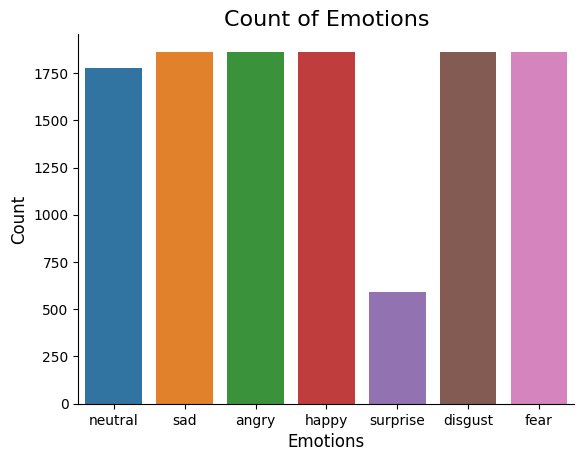

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=Dataset_df['Emotions'])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
print(Dataset_df.Emotions.value_counts())

sad         1863
angry       1863
happy       1863
disgust     1863
fear        1863
neutral     1775
surprise     592
Name: Emotions, dtype: int64


# Esplorazione dei dati

Basandosi sullo stato dell'arte realtivo alle applicazioni di "Speech Emotion Recognition" e, in generale aplicazioni in cui ci si poneva come obbiettivo quello di estrarre informazioni da un file audio, sono stati selezionati i coefficienti MFCC.

In [ ]:
sample = Ravdess + 'Actor_01/03-01-01-01-01-01-01.wav'
ipd.Audio(sample)

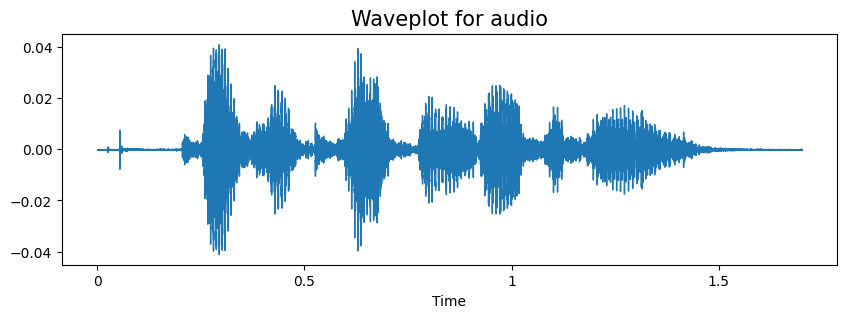

In [ ]:
plt.figure(figsize=(10, 3))
plt.title('Waveplot for audio', size=15)
audio_prova,sample_rate = librosa.load(sample, duration=1.7, offset=0.8)
librosa.display.waveshow(audio_prova, sr=sample_rate)
plt.show()


In [ ]:
mfcc_prova = librosa.feature.mfcc(y=audio_prova)
print(mfcc_prova.shape)

(20, 74)


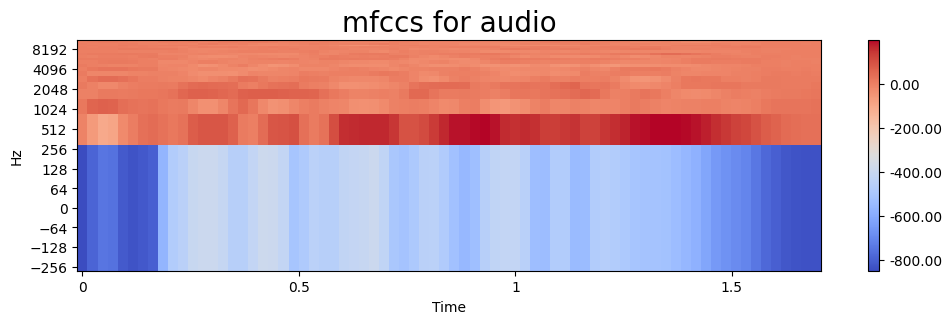

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
# Plot the mel spectogram
img = librosa.display.specshow(mfcc_prova,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('mfccs for audio', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Estrazione delle features

Di seguioèdefinita la funzione per l'estrazione delle caratteristiche che utilicca i coefficienti MFCC

In [ ]:
def mfcc(data,sr):
  max_pad_len=225
  mfccs=librosa.feature.mfcc(y=data,sr=sr, n_mfcc=30)
  pad_width = max_pad_len - mfccs.shape[1]
  mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
  return mfccs



Di seguito è definito la funzione che estrae le caratteristiche selezionate

In [ ]:
def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration, offset=offset)
    audio=mfcc(data,sr=22050)

    return audio



In [ ]:
get_features(sample).shape

(30, 225)

Per ogni file dei dataset vengono estratte le carattristiche

In [ ]:

from tqdm import tqdm
features = []
X,Y=[],[]
for path,emotion,index in tqdm (zip(Dataset_df.Path,Dataset_df.Emotions,range(Dataset_df.Path.shape[0]))):
    X = get_features(path)
    features.append([X, emotion])


11682it [51:35,  3.77it/s]


In [ ]:
# Convert into a Panda dataframe
Features_df = pd.DataFrame(features, columns=['features','emotion'])
Features_df.to_csv('MFCCs_df', index=False)
Features_df


,features,emotion
0,"[[-877.97406, -877.89685, -877.89825, -873.641...",neutral
1,"[[-886.1631, -887.5114, -890.3942, -887.2486, ...",neutral
2,"[[-942.70996, -942.70996, -941.46094, -941.494...",neutral
3,"[[-911.4157, -911.4157, -911.4157, -911.4157, ...",neutral
4,"[[-851.35657, -851.4768, -851.4768, -851.4768,...",neutral
...,...,...
11677,"[[-285.81555, -278.2502, -314.0048, -339.98706...",disgust
11678,"[[-280.44733, -309.11316, -393.59277, -397.617...",disgust
11679,"[[-317.678, -319.75858, -338.36868, -308.61185...",disgust
11680,"[[-387.3249, -381.72488, -387.16788, -373.9640...",disgust


Alcuni valori delle caratteristiche potrebbero essere NaN e quindi è necessario investigare se sono presenti del set di dati

In [ ]:
Features_df.isna().values.any()

False

Di seguito di creano i due set di dati: training e testing

In [ ]:
X = np.array(Features_df.features.tolist())
y = np.array(Features_df.emotion.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 3)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9345, 30, 225)
(9345, 7)
(2337, 30, 225)
(2337, 7)


I due set di dati venogno adattati all'input rieschiesto da una rete neurale, ovvero la forma di un'immagine

In [ ]:
num_rows = 30
num_columns = 225
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
print(x_train.shape)
print(x_test.shape)

num_labels = yy.shape[1]
filter_size = 3

(9345, 30, 225, 1)
(2337, 30, 225, 1)


In [ ]:
x_train[0].shape

(30, 225, 1)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

#Modello

In [ ]:
input_dim = (num_rows, num_columns, num_channels)

In [ ]:
def cnn_block(num_filter, kernel_size):
  model = Sequential()
  model.add(Conv2D(num_filter, kernel_size, padding = "same", activation = "relu"))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  return model

In [ ]:
input1 = Input(shape=(input_dim))
hidden1 = cnn_block(128,5)(input1)
hidden2 = cnn_block(64,3)(hidden1)
hidden3 = cnn_block(64,3)(hidden2)
hidden4 = Flatten()(hidden3)
hidden5 = Dense(128, activation='relu')(hidden4)
hidden6 = Dropout(0.3)(hidden5)
hidden7 = Dense(64, activation='relu')(hidden6)
hidden8 = Dropout(0.3)(hidden7)
output = Dense(7, activation='softmax')(hidden8)


In [ ]:
model = Model(inputs=input1, outputs=output)

model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 225, 1)]      0         
                                                                 
 sequential_5 (Sequential)   (None, 15, 112, 128)      3840      
                                                                 
 sequential_6 (Sequential)   (None, 7, 56, 64)         74048     
                                                                 
 sequential_7 (Sequential)   (None, 3, 28, 64)         37184     
                                                                 
 flatten_2 (Flatten)         (None, 5376)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               688256    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0   

In [ ]:
history=model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/50
293/293 [==============================] - 13s 25ms/step - loss: 1.8657 - acc: 0.2289 - val_loss: 1.7414 - val_acc: 0.2644
Epoch 2/50
293/293 [==============================] - 7s 24ms/step - loss: 1.7350 - acc: 0.2565 - val_loss: 1.6018 - val_acc: 0.3000
Epoch 3/50
293/293 [==============================] - 7s 24ms/step - loss: 1.6922 - acc: 0.2759 - val_loss: 1.7661 - val_acc: 0.2422
Epoch 4/50
293/293 [==============================] - 7s 24ms/step - loss: 1.6354 - acc: 0.3142 - val_loss: 1.4862 - val_acc: 0.3984
Epoch 5/50
293/293 [==============================] - 7s 23ms/step - loss: 1.5958 - acc: 0.3326 - val_loss: 1.4401 - val_acc: 0.3954
Epoch 6/50
293/293 [==============================] - 7s 24ms/step - loss: 1.5746 - acc: 0.3445 - val_loss: 1.4818 - val_acc: 0.3851
Epoch 7/50
293/293 [==============================] - 7s 23ms/step - loss: 1.5464 - acc: 0.3679 - val_loss: 1.5801 - val_acc: 0.3398
Epoch 8/50
293/293 [==============================] - 7s 24ms/step -

74/74 [==============================] - 1s 8ms/step - loss: 1.4171 - acc: 0.6123
Accuracy on test data :  61.232346296310425 %


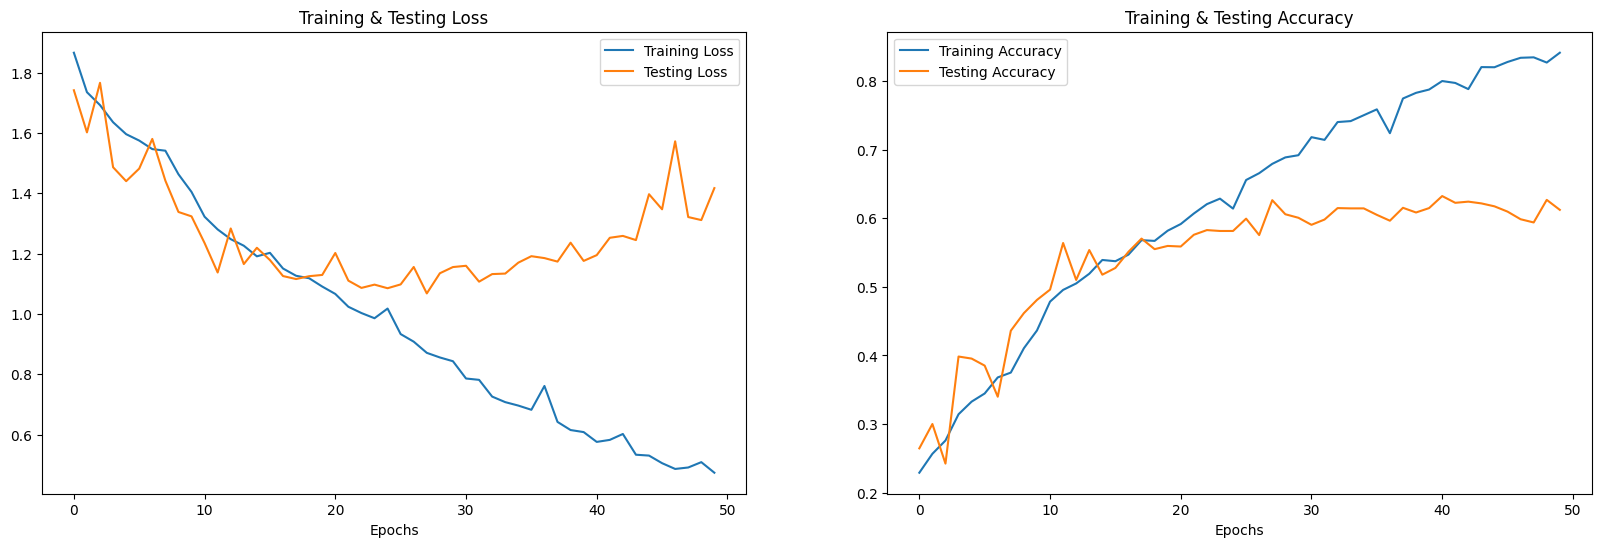

In [ ]:
print("Accuracy on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()